This notebook investigates the relative performance of scipy, numpy, and pyculib for FFTs

In [1]:
import time

import numpy as np
from numpy.fft import fft2 as nfft2, fftshift as nfftshift
from scipy.fftpack import fft2 as sfft2, fftshift as sfftshift
from prysm.mathops import cu_fft2

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def npfft2(array):
    return nfftshift(nfft2(nfftshift(array)))

def spfft2(array):
    return sfftshift(sfft2(sfftshift(array)))

def cufft2(array):
    return nfftshift(cu_fft2(nfftshift(array)))

arr_sizes = [16, 32, 128, 256, 512, 1024, 2048, 4048, 8096]  # 8096x8096 arrays will require ~6GB of RAM to run
def test_algorithm_speed(function):
    data = [np.random.rand(size, size) for size in arr_sizes]
    times = []
    for dat in data:
        t0 = time.time()
        try:
            function(dat)
            t1 = time.time()
            times.append(t1-t0)
        except Exception as e:
            # probably cuFFT error -- array too big to fit in GPU memory
            times.append(np.nan)
    return times

In [3]:
ntrials = 5
results_np = np.empty((len(arr_sizes),ntrials), dtype='float64')
results_sp = np.empty((len(arr_sizes),ntrials), dtype='float64')
results_cu = np.empty((len(arr_sizes),ntrials), dtype='float64')
for t in range(ntrials):
    results_np[:,t] = test_algorithm_speed(npfft2)
    results_sp[:,t] = test_algorithm_speed(spfft2)
    results_cu[:,t] = test_algorithm_speed(cufft2)

results_np *= 1e3
results_sp *= 1e3
results_cu *= 1e3

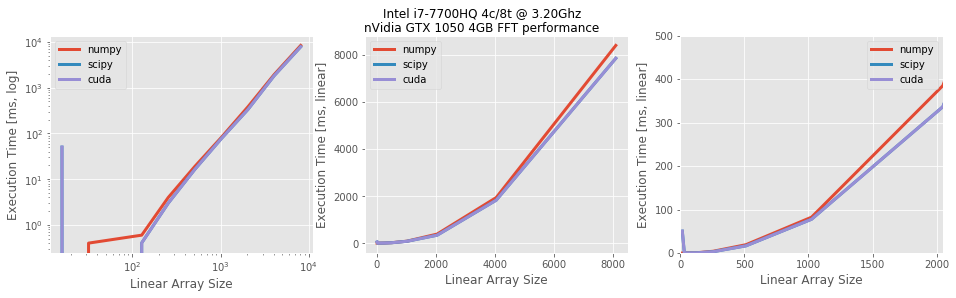

In [20]:
cpu = 'Intel i7-7700HQ 4c/8t @ 3.20Ghz\nnVidia GTX 1050 4GB'
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,4))
ax1.plot(arr_sizes, results_np.mean(axis=1), lw=3, label='numpy')
ax1.plot(arr_sizes, results_sp.mean(axis=1), lw=3, label='scipy')
ax1.plot(arr_sizes, results_sp.mean(axis=1), lw=3, label='cuda')
ax1.legend()
ax1.set(xscale='log', xlabel='Linear Array Size',
       yscale='log', ylabel='Execution Time [ms, log]')

ax2.plot(arr_sizes, results_np.mean(axis=1), lw=3, label='numpy')
ax2.plot(arr_sizes, results_sp.mean(axis=1), lw=3, label='scipy')
ax2.plot(arr_sizes, results_sp.mean(axis=1), lw=3, label='cuda')
ax2.legend()
ax2.set(xlabel='Linear Array Size', ylabel='Execution Time [ms, linear]')

ax3.plot(arr_sizes, results_np.mean(axis=1), lw=3, label='numpy')
ax3.plot(arr_sizes, results_sp.mean(axis=1), lw=3, label='scipy')
ax3.plot(arr_sizes, results_sp.mean(axis=1), lw=3, label='cuda')
ax3.legend()
ax3.set(xlabel='Linear Array Size', ylabel='Execution Time [ms, linear]', xlim=(0,2048), ylim=(0,500))
plt.suptitle(cpu + ' FFT performance');


note that GPU performance is currently severely handicapped by transfer from CPU<-->GPU, and fftshifts being done in numpy and not on the GPU itself.